In [1]:
import numpy as np
from numpy import array
from math import pi
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt

In [1]:
from FFT import FFT

In [2]:
image_path_list = ['baboon', 'F16', 'lena', 'Noisy']
image_list = [np.fromfile("./data/"+path+".raw", dtype=np.uint8).reshape(512, 512) for path in image_path_list]

In [3]:
def re_scale(image):
    min_value, max_value = image.min(), image.max()
    result = 255 * (image - min_value) / (max_value - min_value)
    return result.astype(np.uint8)

In [4]:
def freq_padding(image:np.array):
    nrow, ncols = image.shape[0], image.shape[1]
    new_size = np.power(2, np.floor(np.log2([nrow, ncols])+1))
    output = np.zeros(new_size)
    output[:nrows,:ncols] = image
    return output

In [5]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
            .swapaxes(1,2)
            .reshape(-1, nrows, ncols))

In [6]:
def DFT(image:np.array):
    nrows, ncols = image.shape[0], image.shape[1]
    all_row_index, all_col_index = np.indices((nrows, ncols))

    norm_all_row_index = all_row_index / nrows
    norm_all_col_index = all_col_index / ncols

    index_array = np.kron(all_row_index, norm_all_row_index) + np.kron(all_col_index, norm_all_col_index)
    weighted = np.exp(-array([1j]) * 2 * pi * index_array)
    weighted_array_list = blockshaped(weighted, nrows, ncols)
    result = list(map(lambda x: np.sum(x*image), weighted_array_list))
    return array(result).reshape(nrows, ncols)

In [7]:
def dft_matrix(input_img):
    rows = input_img.shape[0]
    cols = input_img.shape[1]
    t = np.zeros((rows,cols),complex)
    output_img = np.zeros((rows,cols),complex)
    m = np.arange(rows)
    n = np.arange(cols)
    x = m.reshape((rows,1))
    y = n.reshape((cols,1))
    for row in range(0,rows):
        M1 = 1j*np.sin(-2*np.pi*y*n/cols) + np.cos(-2*np.pi*y*n/cols)
        t[row] = np.dot(M1, input_img[row])
    for col in range(0,cols):
        M2 = 1j*np.sin(-2*np.pi*x*m/cols) + np.cos(-2*np.pi*x*m/cols)
        output_img[:,col] = np.dot(M2, t[:,col])
    return output_img

In [31]:
def FFT(image):
    image = np.asarray(image, dtype=float)
    nrows, ncols = image.shape[-2], image.shape[-1]
    
    if (nrows % 2 > 0) or (nrows != ncols):
        raise ValueError("size of x must be a power of 2 and (height, width) should equal.")
    elif nrows <= 32:
        return DFT(image)
        # if len(image.shape) == 2:
        #     return DFT(image)
        # elif len(image.shape) == 3:
        #     return np.apply_along_axis(DFT, axis=0, arr=image)
    else:
        # if len(image.shape) == 2:
        #     stack_image = np.stack([image[::2,::2], image[::2,::2], image[::2,1::2], image[1::2,1::2]],axis=0)
        # elif len(image.shape) == 3:
        #     stack_image = np.concatenate([image[:,::2,::2], image[:,::2,::2], image[:,::2,1::2], image[:,1::2,1::2]],axis=0)
        # row_even_col_even, row_odd_col_even, row_even_col_odd, row_odd_col_odd = np.apply_along_axis(FFT, axis=0, arr=stack_image)
        row_even_col_even = FFT(image[::2,::2])
        row_odd_col_even = FFT(image[1::2,::2])
        row_even_col_odd = FFT(image[::2,1::2])
        row_odd_col_odd = FFT(image[1::2,1::2])
        
        row_factor = np.exp(-2j * np.pi * np.arange(nrows) / nrows)
        col_factor = np.exp(-2j * np.pi * np.arange(ncols) / ncols)
        row_factor_matrix = np.repeat(row_factor.reshape(1,-1),repeats=nrows, axis=0)
        col_factor_matrix = np.repeat(col_factor.reshape(-1,1),repeats=ncols, axis=1)

        # concatenate block matrix

        block_11 = row_even_col_even + \
            row_factor_matrix[:int(nrows / 2),:int(nrows / 2)] * row_odd_col_even + \
            col_factor_matrix[:int(nrows / 2),:int(nrows / 2)] * row_even_col_odd + \
            row_factor_matrix[:int(nrows / 2),:int(nrows / 2)] * col_factor_matrix[:int(nrows / 2),:int(nrows / 2)] * row_odd_col_odd

        block_12 = row_even_col_even + \
            row_factor_matrix[:int(nrows / 2),int(nrows / 2):] * row_odd_col_even + \
            col_factor_matrix[:int(nrows / 2),int(nrows / 2):] * row_even_col_odd + \
            row_factor_matrix[:int(nrows / 2),int(nrows / 2):] * col_factor_matrix[:int(nrows / 2),int(nrows / 2):] * row_odd_col_odd

        block_21 = row_even_col_even + \
            row_factor_matrix[int(nrows / 2):,:int(nrows / 2)] * row_odd_col_even + \
            col_factor_matrix[int(nrows / 2):,:int(nrows / 2)] * row_even_col_odd + \
            row_factor_matrix[int(nrows / 2):,:int(nrows / 2)] * col_factor_matrix[int(nrows / 2):,:int(nrows / 2)] * row_odd_col_odd


        block_22 = row_even_col_even + \
            row_factor_matrix[int(nrows / 2):,int(nrows / 2):] * row_odd_col_even + \
            col_factor_matrix[int(nrows / 2):,int(nrows / 2):] * row_even_col_odd + \
            row_factor_matrix[int(nrows / 2):,int(nrows / 2):] * col_factor_matrix[int(nrows / 2):,int(nrows / 2):] * row_odd_col_odd
        
        return np.block([
            [block_11, block_12],
            [block_21, block_22]
        ])

In [34]:
from memory_profiler import memory_usage

In [37]:
FFT(image_list[0])

array([[33375714.              +0.j        ,
         -673676.9886633  +240837.25100186j,
          400828.99474452 -175208.10087739j, ...,
          929609.87905641  +87871.49710568j,
          400828.99474455 +175208.10087739j,
         -673676.98866324 -240837.25100189j],
       [ -296319.63767477 +170485.73658351j,
         1572182.48509466 -333206.83586242j,
           62001.93672944 +222006.46503995j, ...,
        -1134552.85116988 +175499.40781625j,
         -399675.92253083 +494341.03284717j,
          714847.12982861 +122805.11681421j],
       [ -376786.88320605+1789871.98040337j,
         -633558.42114245 -520189.03126661j,
         -144348.2510632  -509734.5671362j , ...,
          541170.2218852  +148840.5216335j ,
          176069.56113306 -638973.86586163j,
         -811150.75100784 -616511.65908359j],
       ...,
       [   86665.40772032 -571340.51395776j,
         -424732.09180533 +448756.26095703j,
          104774.29802989 -204692.90490782j, ...,
           89632.092

In [32]:
fft2(image_list[0])

array([[33375714.              -0.j        ,
         -670658.11357088 +244233.54431323j,
          408077.3274185  -179004.42663654j, ...,
          954513.22016302  +76124.39449393j,
          408077.3274185  +179004.42663654j,
         -670658.11357088 -244233.54431323j],
       [ -294179.79420403 +179031.46098521j,
         1572182.48509465 -333206.83586242j,
           62803.71706823 +221793.89157652j, ...,
        -1162567.07088937 +184085.17535098j,
         -407178.37067264 +510823.14218354j,
          731156.67656464 +128712.11060386j],
       [ -377893.94078963+1822414.69572112j,
         -638180.75571244 -520404.6483363j ,
         -144348.2510632  -509734.5671362j , ...,
          578462.37044904 +138899.36596058j,
          183224.22684683 -661700.21380548j,
         -836502.07724738 -631771.26279805j],
       ...,
       [   90992.31855627 -590255.37282135j,
         -437793.80630412 +456392.75010577j,
          106952.27237557 -229487.3909334j , ...,
           89632.092

In [12]:
array([[1,2,3,4],[2,4,6,8],[1,2,3,4],[2,4,6,8]])[1::2,::2]

array([[2, 6],
       [2, 6]])

In [ ]:
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 4:  # this cutoff should be optimized
        return x+1
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)

        print(N, "\n", X_even,  "\n", X_odd,  "\n", factor)

        return np.concatenate([X_even + factor[:int(N / 2)] * X_odd,
                               X_even + factor[int(N / 2):] * X_odd])

In [38]:
class Frequency_transform(object):

    # Discrete fourier transform of 2D image
    ## array(nrows, ncols) -> array(nrows, ncols)
    def DFT(self, image:np.array):
        
        nrows, ncols = image.shape[0], image.shape[1]
        output = np.zeros((nrows, ncols),dtype=np.complex_)

        sub_image_list, all_cut_index_list = self.split_image(image)
        cut_row_start_index, cut_row_end_index, cut_col_start_index, cut_col_end_index = all_cut_index_list
        
        sub_freq_map_list = list(map(self.FDFT, sub_image_list))
        
        iter_num = 0
        for start_row, end_row in zip(cut_row_start_index, cut_row_end_index):
            for start_col, end_col in zip(cut_col_start_index, cut_col_end_index):
                output[start_row:end_row,start_col:end_col] = sub_freq_map_list[iter_num]
                iter_num += 1

        return output

    # Inverse discrete fourier transform of 2D image
    ## array(nrows, ncols) -> array(nrows, ncols)
    def IDFT(self, freq_map):
        nrows, ncols = freq_map.shape[0], freq_map.shape[1]
        output = np.zeros((nrows, ncols),dtype=np.complex_)

        sub_freq_map_list, all_cut_index_list = self.split_image(freq_map)
        cut_row_start_index, cut_row_end_index, cut_col_start_index, cut_col_end_index = all_cut_index_list
        
        sub_image_list = list(map(self.FIDFT, sub_freq_map_list))
        
        iter_num = 0
        for start_row, end_row in zip(cut_row_start_index, cut_row_end_index):
            for start_col, end_col in zip(cut_col_start_index, cut_col_end_index):
                output[start_row:end_row,start_col:end_col] = sub_image_list[iter_num]
                iter_num += 1

        return output

    # Without for loop: Discrete fourier transform of 2D image
    ## Advantage: Simple and probably faster
    ## Disadvantage: Need a lot of memory
    def FDFT(self, image:np.array):
        nrows, ncols = image.shape[0], image.shape[1]
        all_row_index, all_col_index = np.indices((nrows, ncols))

        norm_all_row_index = all_row_index / nrows
        norm_all_col_index = all_col_index / ncols

        index_array = np.kron(all_row_index, norm_all_row_index) + np.kron(all_col_index, norm_all_col_index)
        weighted = np.exp(-array([1j]) * 2 * pi * index_array)
        weighted_array_list = self.blockshaped(weighted, nrows, ncols)
        result = list(map(lambda x: np.sum(x*image), weighted_array_list))
        return array(result).reshape(nrows, ncols)
        
    # Without for loop: Inverse discrete fourier transform of 2D image
    ## Advantage: Simple and probably faster
    ## Disadvantage: Need a lot of memory
    def FIDFT(self, freq_map):
        nrows, ncols = freq_map.shape[0], freq_map.shape[1]
        freq_map = freq_map / (nrows*ncols)
        all_row_index, all_col_index = np.indices((nrows, ncols))

        norm_all_row_index = all_row_index / nrows
        norm_all_col_index = all_col_index / ncols
        index_array = np.kron(all_row_index, norm_all_row_index) + np.kron(all_col_index, norm_all_col_index)
        weighted = np.exp(array([1j]) * 2 * pi * index_array)
        weighted_array_list = self.blockshaped(weighted, nrows, ncols)
        result = list(map(lambda x: np.sum(x*freq_map), weighted_array_list))
        return array(result).reshape(nrows, ncols)

    # https://stackoverflow.com/questions/11105375/how-to-split-a-matrix-into-4-blocks-using-numpy
    # https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
    def blockshaped(self, arr, nrows, ncols):
        """
        Return an array of shape (n, nrows, ncols) where
        n * nrows * ncols = arr.size

        If arr is a 2D array, the returned array should look like n subblocks with
        each subblock preserving the "physical" layout of arr.
        """
        h, w = arr.shape
        assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
        assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
        return (arr.reshape(h//nrows, nrows, -1, ncols)
                .swapaxes(1,2)
                .reshape(-1, nrows, ncols))

    def split_image(self, image):
        nrows, ncols = image.shape[0], image.shape[1]

        cut_row_index = np.linspace(start=0, stop=nrows, num=((nrows-1)//30)+2, endpoint=True, dtype=np.int32)
        cut_row_start_index = cut_row_index[:-1]
        cut_row_end_index = cut_row_index[1:]

        cut_col_index = np.linspace(start=0, stop=ncols, num=((ncols-1)//30)+2, endpoint=True, dtype=np.int32)
        cut_col_start_index = cut_col_index[:-1]
        cut_col_end_index = cut_col_index[1:]
        
        sub_image_list = []
        for start_row, end_row in zip(cut_row_start_index, cut_row_end_index):
            for start_col, end_col in zip(cut_col_start_index, cut_col_end_index):
                sub_image_list.append(image[start_row:end_row, start_col:end_col])

        all_cut_index_list = [cut_row_start_index, cut_row_end_index, cut_col_start_index, cut_col_end_index]

        return sub_image_list, all_cut_index_list

In [39]:
F_trans = Frequency_transform()

In [35]:
padding_image_list = []
for sub_image in image_list:
    nrows, ncols = sub_image.shape
    output = np.zeros((2*nrows, 2*ncols), dtype=np.uint8)
    output[:nrows,:ncols] = sub_image
    padding_image_list.append(output)

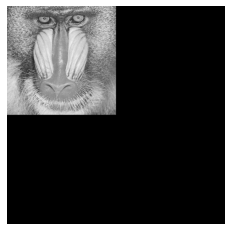

In [36]:
plt.imshow(padding_image_list[0], cmap='gray')
plt.axis("off")
plt.show()

In [40]:
scipy_freq_image_list = list(map(lambda x: fft2(x), padding_image_list))

In [43]:
my_freq_image_list = list(map(lambda x: F_trans.DFT(x), padding_image_list))

In [45]:
from tqdm import tqdm

In [47]:
my_fft_freq_image_list = []

In [48]:
for img in tqdm(padding_image_list):
    my_fft_freq_image_list.append(FFT(img))

100%|██████████| 4/4 [10:50<00:00, 162.61s/it]


In [66]:
re_scale(np.log(abs(scipy_freq_image_list[img_index]))) - np.log(abs(scipy_freq_image_list[img_index]))

array([[237.62253261, 231.06526943, 196.4925643 , ..., 213.29133893,
        196.4925643 , 231.06526943],
       [231.07147914, 223.59265879, 185.27953717, ..., 205.80765376,
        196.50045059, 225.45616458],
       [188.04163905, 191.77900751, 195.5099531 , ..., 174.98809355,
        181.5338585 , 192.74360817],
       ...,
       [215.15697399, 209.57164081, 184.29627388, ..., 198.3690779 ,
        193.68974614, 210.49668122],
       [188.04163905, 192.74360817, 181.5338585 , ..., 190.8801533 ,
        195.5099531 , 191.77900751],
       [231.07147914, 225.45616458, 196.50045059, ..., 207.68175417,
        185.27953717, 223.59265879]])

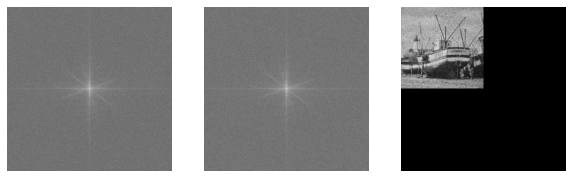

In [71]:
img_index = 3

fig, ax = plt.subplots(figsize=(10,11), ncols=3)
ax[0].imshow(np.fft.fftshift(re_scale(np.log(abs(scipy_freq_image_list[img_index]))).astype(np.uint8)), cmap='gray')
ax[0].axis("off")

ax[1].imshow(np.fft.fftshift(np.log(abs(scipy_freq_image_list[img_index])).astype(np.uint8)), cmap='gray')
ax[1].axis("off")

ax[2].imshow(padding_image_list[img_index], cmap='gray')
ax[2].axis("off")

plt.show()

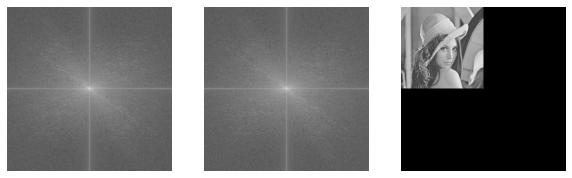

In [73]:
img_index = 2

fig, ax = plt.subplots(figsize=(10,11), ncols=3)
ax[0].imshow(np.fft.fftshift(re_scale(np.log(abs(scipy_freq_image_list[img_index]))).astype(np.uint8)), cmap='gray')
ax[0].axis("off")

ax[1].imshow(np.fft.fftshift(np.log(abs(scipy_freq_image_list[img_index])).astype(np.uint8)), cmap='gray')
ax[1].axis("off")

ax[2].imshow(padding_image_list[img_index], cmap='gray')
ax[2].axis("off")

plt.show()

In [213]:
freq_image_list = list(map(F_trans.DFT, image_list))

In [11]:
scipy_freq_image_list = []
for sub_image in image_list:
    nrows, ncols = sub_image.shape[0], sub_image.shape[1]
    new_size = np.power(2, np.ceil(np.log2(array([nrows, ncols]))+1)).astype(np.int32)
    output = np.zeros(new_size, dtype=np.complex_)
    output[:nrows, :ncols] = sub_image
    scipy_freq_image_list.append(fft2(output))

In [311]:
def re_scale(image):
    max_value, min_value = image.max(), image.min()
    return 255*(image - min_value)/(max_value-min_value)

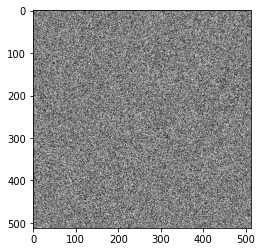

In [313]:
plt.imshow((np.real(scipy_freq_image_list[0])).astype(np.uint8), cmap="gray")

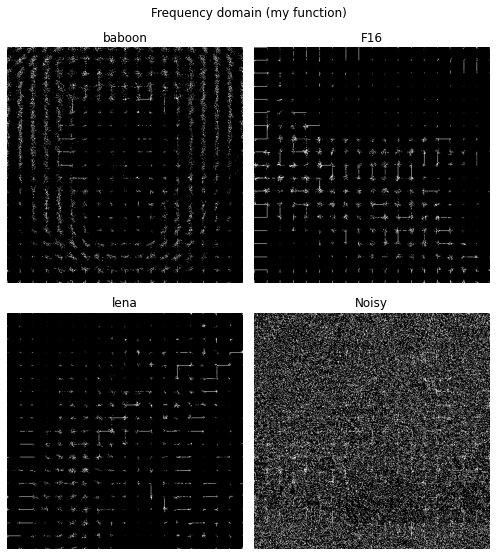

In [230]:
fig, ax = plt.subplots(figsize=(7,8), nrows=2, ncols=2)
for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(np.real(freq_image_list[i]).astype(np.uint8), cmap='gray')
    ax_i.axis("off")
    ax_i.set_title(image_path_list[i])

fig.suptitle("Frequency domain (my function)")
fig.tight_layout()
plt.show()

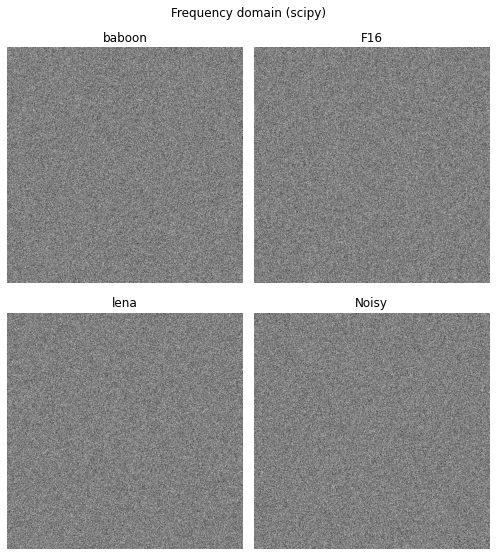

In [14]:
fig, ax = plt.subplots(figsize=(7,8), nrows=2, ncols=2)
for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(np.abs(scipy_freq_image_list[i]).astype(np.uint8), cmap='gray')
    ax_i.axis("off")
    ax_i.set_title(image_path_list[i])

fig.suptitle("Frequency domain (scipy)")
fig.tight_layout()
plt.show()

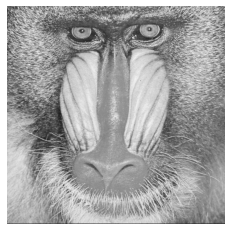

In [244]:
plt.imshow(image_list[0], cmap='gray')
plt.axis("off")
plt.show()

In [247]:
N = 6
test_arr = np.exp(-2j * np.pi * np.arange(N) / N)

In [250]:
test_arr, test_arr[:int(N/2)]

(array([ 1. +0.00000000e+00j,  0.5-8.66025404e-01j, -0.5-8.66025404e-01j,
        -1. -1.22464680e-16j, -0.5+8.66025404e-01j,  0.5+8.66025404e-01j]),
 array([ 1. +0.j       ,  0.5-0.8660254j, -0.5-0.8660254j]))

In [279]:
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 4:  # this cutoff should be optimized
        return x+1
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)

        print(N, "\n", X_even,  "\n", X_odd,  "\n", factor)

        return np.concatenate([X_even + factor[:int(N / 2)] * X_odd,
                               X_even + factor[int(N / 2):] * X_odd])

In [292]:
def bilinear_resize_vectorized(image, height, width):
  """
  `image` is a 2-D numpy array
  `height` and `width` are the desired spatial dimension of the new 2-D array.
  """
  img_height, img_width = image.shape

  image = image.ravel()

  x_ratio = float(img_width - 1) / (width - 1) if width > 1 else 0
  y_ratio = float(img_height - 1) / (height - 1) if height > 1 else 0

  y, x = np.divmod(np.arange(height * width), width)

  x_lower = np.floor(x_ratio * x).astype('int32')
  y_lower = np.floor(y_ratio * y).astype('int32')

  x_upper = np.ceil(x_ratio * x).astype('int32')
  y_upper = np.ceil(y_ratio * y).astype('int32')

  x_weight = (x_ratio * x) - x_lower
  y_weight = (y_ratio * y) - y_lower

  traget_a = image[y_lower * img_width + x_lower]
  traget_b = image[y_lower * img_width + x_upper]
  traget_c = image[y_upper * img_width + x_lower]
  traget_d = image[y_upper * img_width + x_upper]

  traget = traget_a * (1 - x_weight) * (1 - y_weight) + \
           traget_b * x_weight * (1 - y_weight) + \
           traget_c * y_weight * (1 - x_weight) + \
           traget_d * x_weight * y_weight

  return traget.reshape(height, width)

In [293]:
new_size = np.power(2, np.ceil(np.log2(array(image_list[0].shape)))).astype(np.int32).tolist()

In [294]:
new_image = bilinear_resize_vectorized(image_list[0], new_size[0], new_size[1])

In [295]:
new_image

array([[141.,  64.,  58., ..., 113., 148., 168.],
       [116., 103.,  50., ..., 128., 144., 124.],
       [ 82., 114.,  56., ..., 102.,  92.,  86.],
       ...,
       [137., 141., 137., ...,  87.,  93.,  83.],
       [150., 137., 129., ...,  84.,  85.,  75.],
       [ 25.,  26.,  29., ...,  22.,  19.,  20.]])

In [280]:
FFT(array(list(range(8))))

8 
 [1. 3. 5. 7.] 
 [2. 4. 6. 8.] 
 [ 1.00000000e+00+0.00000000e+00j  7.07106781e-01-7.07106781e-01j
  6.12323400e-17-1.00000000e+00j -7.07106781e-01-7.07106781e-01j
 -1.00000000e+00-1.22464680e-16j -7.07106781e-01+7.07106781e-01j
 -1.83697020e-16+1.00000000e+00j  7.07106781e-01+7.07106781e-01j]


array([ 3.        +0.00000000e+00j,  5.82842712-2.82842712e+00j,
        5.        -6.00000000e+00j,  1.34314575-5.65685425e+00j,
       -1.        -2.44929360e-16j,  0.17157288+2.82842712e+00j,
        5.        +6.00000000e+00j, 12.65685425+5.65685425e+00j])